# Experiment with different Dimensionality Reduction techniques and its plots

In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
embeddings, movie_ids  = load_movie_embeddings(os.path.join(base_path, "data", 'data_final'))

In [3]:
embeddings.shape

(87718, 1024)

In [4]:
movie_df = pd.read_csv(os.path.join(base_path, "data", "data_final", "cleaned_movie_data.csv"), dtype=str, low_memory=False)

In [5]:
movie_df.shape

(98494, 32)

In [6]:
movie_df = movie_df[movie_df.genre.notna()].reset_index(drop=True)

In [7]:
movie_df["new_genre"] = movie_df["genre"].apply(preprocess_genres)

In [9]:
import json

In [8]:
with open("../cluster_to_genre_mapping_01122025.json", "r") as f:
    genre_fix_mapping = json.load(f)

In [10]:
movie_df = movie_df[movie_df["new_genre"] != "Unknown"].reset_index(drop=True)

In [11]:
movie_df["new_genre"] = movie_df["new_genre"].apply(lambda x: [genre_fix_mapping[i] for i in x.split("|")])

In [12]:
embeddings.shape, movie_ids.shape

((87718, 1024), (87718,))

In [13]:
movie_id_to_embedding_map = {
    movie_id: embeddings[idx]
    for idx, movie_id in enumerate(movie_df.movie_id)
}

In [14]:
movie_df = movie_df[movie_df.movie_id.isin(movie_ids)].reset_index(drop=True)

In [15]:
def contains_old_genre(genre_raw_string: str, query_genre: str) -> bool:
    genre_raw_string_lowered = genre_raw_string.lower()
    query_genre_lowered = query_genre.lower()
    return query_genre_lowered in genre_raw_string_lowered

# PCA

## Scifi movies
For this notebook, we are trying only with Scifi data

In [16]:
# Filter data only for scifi movies
scifi_df = movie_df[movie_df["genre"].apply(lambda x: contains_old_genre(x, "science fiction film"))].reset_index(drop=True)

In [17]:
scifi_df.shape

(3478, 33)

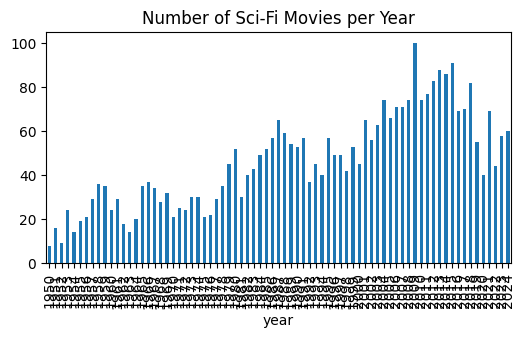

In [18]:
scifi_df.groupby("year").size().plot(kind="bar", figsize=(6, 3))
plt.title("Number of Sci-Fi Movies per Year");

### Most average scifi movies per year

Here we use cosine distance to find the arg min movie per year, basically the movie which is the most similar (has the lowest cosine distance from every other movie in that year).

**Note** that I am using the old genres, it is more granular.

In [19]:
from math_functions.cosine_distance_util import find_nearest_and_furthest_medoid

In [20]:
scifi_df_embeddings = np.array([movie_id_to_embedding_map[movie_id] for movie_id in scifi_df.movie_id.unique().tolist()])

In [21]:
scifi_df_embeddings.shape

(3478, 1024)

In [22]:
near_ind, far_ind = find_nearest_and_furthest_medoid(scifi_df_embeddings)

In [23]:
scifi_df.iloc[near_ind]["plot"]

"Moments after the end of the second film, the mutant squirrel Tromie is subdued and life in Tromaville returns to normal. Roger Smith, now mayor of Tromaville, is overjoyed at the birth of his twin sons, Dick and Adlai. Unfortunately for all concerned parties, Dick is kidnapped at the hospital and subsequently raised to be evil by the thugs who took him. Adlai, meanwhile, is raised by Roger to be kind and peaceful. Flashing-forward several years into the future, when Dick and Adlai are adults, trouble comes in the form of the loathsome Dr. Slag, Ph.D., who uses Dick to frame Adlai for a crime he did not commit in the hopes of turning the denizens of Tromaville against him. If his wily plot works, Slag will turn the town into a toxic wasteland; with destruction looming, it is up to Adlai to save the day. The plot is loosely based on William Shakespeare's The Comedy of Errors. The only thing carried over is the storyline of the twins being separated and a later identity crisis following

In [24]:
scifi_df.iloc[far_ind]["plot"]

'Agnes falls in love with the wrong man and then gets reincarnated and falls in love with him over and over again, travelling through 1680s western Scotland, rural England in the 1790s, 1980s Manhattan, and a post-apocalyptic 22nd century.'

In [ ]:
from scipy.spatial.distance import cdist

most_ave_scifi_movies = []
for year in sorted(scifi_df.year.unique().tolist()):
    # subset df for the year
    year_scifi_df = scifi_df[scifi_df.year == year].reset_index(drop=True)

    # Get all embeddings for movies in 1950
    year_embeddings =np.array([movie_id_to_embedding_map[movie_id] for movie_id in year_scifi_df["movie_id"].tolist()])

    # Calculate pairwise cosine distance matrix
    year_distance_matrix = cdist(year_embeddings, year_embeddings, metric='cosine')

    year_most_ave_movie = year_scifi_df.iloc[np.argmin(year_distance_matrix.sum(axis=0))]

    most_ave_scifi_movies.append(year_most_ave_movie)

most_ave_scifi_movies_df = pd.DataFrame(most_ave_scifi_movies)

Use PCA to plot and see any trajectory of the most average scifi movie

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# All embeddings for most average scifi movies
most_ave_scifi_embeddings = np.array([movie_id_to_embedding_map[movie_id] for movie_id in most_ave_scifi_movies_df["movie_id"].tolist()])

In [ ]:
most_ave_scifi_movies_df.shape, most_ave_scifi_embeddings.shape

In [72]:
pcaed_embeddings = PCA(n_components=2).fit_transform(most_ave_scifi_embeddings)

In [ ]:
# plot the evolution of pcaed embeddings over the years
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=pcaed_embeddings[:, 0], y=pcaed_embeddings[:, 1], hue=most_ave_scifi_movies_df["year"], palette="viridis", s=100)
for i, year in enumerate(most_ave_scifi_movies_df["year"]):
    plt.text(pcaed_embeddings[i, 0]+0.01, pcaed_embeddings[i, 1]+0.01, year, fontsize=9)
plt.title("PCA of Most Average Sci-Fi Movie Embeddings Over Years")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
ax.get_legend().remove()
plt.grid()
plt.show();

In [ ]:
xs = pcaed_embeddings[:, 0]
ys = pcaed_embeddings[:, 1]

dx = xs[1:] - xs[:-1]
dy = ys[1:] - ys[:-1]

fig, ax = plt.subplots(figsize=(10, 10))


# plot points if you want to see them
ax.scatter(xs, ys)

# arrows from each point to the next
ax.quiver(xs[:-1], ys[:-1], dx, dy,
          angles='xy', scale_units='xy', scale=1,
          width=0.003)


# I also want the first point to be red
ax.scatter(xs[0], ys[0], color='red')

# Last point should be green
ax.scatter(xs[-1], ys[-1], color='green')

ax.set_aspect('equal')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Most Average Sci-Fi Movies Over Time")
plt.show();


In [ ]:
# Try plotting the PCAs of the DIFFERENCE of embeddings year on year
deltas = [most_ave_scifi_embeddings[i+1] - most_ave_scifi_embeddings[i] for i in range(len(most_ave_scifi_embeddings)-1)]
pca = PCA(n_components=2)
delta_proj = pca.fit_transform(deltas)

plt.plot(delta_proj[:,0], delta_proj[:,1], marker='o')
plt.show();

This proved to be absolutely useless. Let me try on another genre, lets say action

## Action movies

In [ ]:
# Filter data only for action movies
action_df = movie_df[movie_df["genre"].apply(lambda x: contains_old_genre(x, "action film"))].reset_index(drop=True)

In [ ]:
action_df.shape

In [ ]:
action_df.groupby("year").size().plot(kind="bar", figsize=(12, 6))
plt.title("Number of Action Movies per Year");

### Most average action movies per year

**Note** that I am STILL using the old genres, it is more granular.

In [ ]:
from scipy.spatial.distance import cdist

most_ave_action_movies = []
for year in sorted(action_df.year.unique().tolist()):
    # subset df for the year
    year_action_df = action_df[action_df.year == year].reset_index(drop=True)

    # Get all embeddings for movies in 1950
    year_embeddings = np.array([movie_id_to_embedding_map[movie_id] for movie_id in year_action_df["movie_id"].tolist()])

    # Calculate pairwise cosine distance matrix
    year_distance_matrix = cdist(year_embeddings, year_embeddings, metric='cosine')

    year_most_ave_movie = year_action_df.iloc[np.argmin(year_distance_matrix.sum(axis=0))]

    most_ave_action_movies.append(year_most_ave_movie)

most_ave_action_movies_df = pd.DataFrame(most_ave_action_movies)

Use PCA to plot and see any trajectory of the most average action movie

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# All embeddings for most average action movies
most_ave_action_embeddings = np.array([movie_id_to_embedding_map[movie_id] for movie_id in most_ave_action_movies_df["movie_id"].tolist()])

In [ ]:
most_ave_action_movies_df.shape, most_ave_action_embeddings.shape

In [ ]:
action_pcaed_embeddings = PCA(n_components=2).fit_transform(most_ave_action_embeddings)

In [ ]:
# plot the evolution of pcaed embeddings over the years
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=action_pcaed_embeddings[:, 0], y=action_pcaed_embeddings[:, 1], hue=most_ave_action_movies_df["year"], palette="viridis", s=100)
for i, year in enumerate(most_ave_action_movies_df["year"]):
    plt.text(action_pcaed_embeddings[i, 0]+0.01, action_pcaed_embeddings[i, 1]+0.01, year, fontsize=9)
plt.title("PCA of Most Average Action Movie Embeddings Over Years")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
ax.get_legend().remove()
plt.grid()
plt.show();

In [ ]:
xs = action_pcaed_embeddings[:, 0]
ys = action_pcaed_embeddings[:, 1]

dx = xs[1:] - xs[:-1]
dy = ys[1:] - ys[:-1]

fig, ax = plt.subplots(figsize=(10, 10))


# plot points if you want to see them
ax.scatter(xs, ys)

# arrows from each point to the next
ax.quiver(xs[:-1], ys[:-1], dx, dy,
          angles='xy', scale_units='xy', scale=1,
          width=0.003)


# I also want the first point to be red
ax.scatter(xs[0], ys[0], color='red')

# Last point should be green
ax.scatter(xs[-1], ys[-1], color='green')

ax.set_aspect('equal')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Most Average Action Movies Over Time")
plt.show();


In [ ]:
# Try plotting the PCAs of the DIFFERENCE of embeddings year on year
deltas = [most_ave_action_embeddings[i+1] - most_ave_action_embeddings[i] for i in range(len(most_ave_action_embeddings)-1)]
pca = PCA(n_components=2)
delta_proj = pca.fit_transform(deltas)

plt.plot(delta_proj[:,0], delta_proj[:,1], marker='o')
plt.show();

This is still fking useless. Let me try with a broader genre (new genres).

## New genre (Scifi movies)
Since the previous experiment we cannot see any sort of "trajectory" of the most average movie per year, I want to try it with a more general genre classification.

In [ ]:
def contains_new_genre(genre_list: list, query_genre: str) -> bool:
    genre_list_lowered = [g.lower() for g in genre_list]
    query_genre_lowered = query_genre.lower()
    return query_genre_lowered in genre_list_lowered

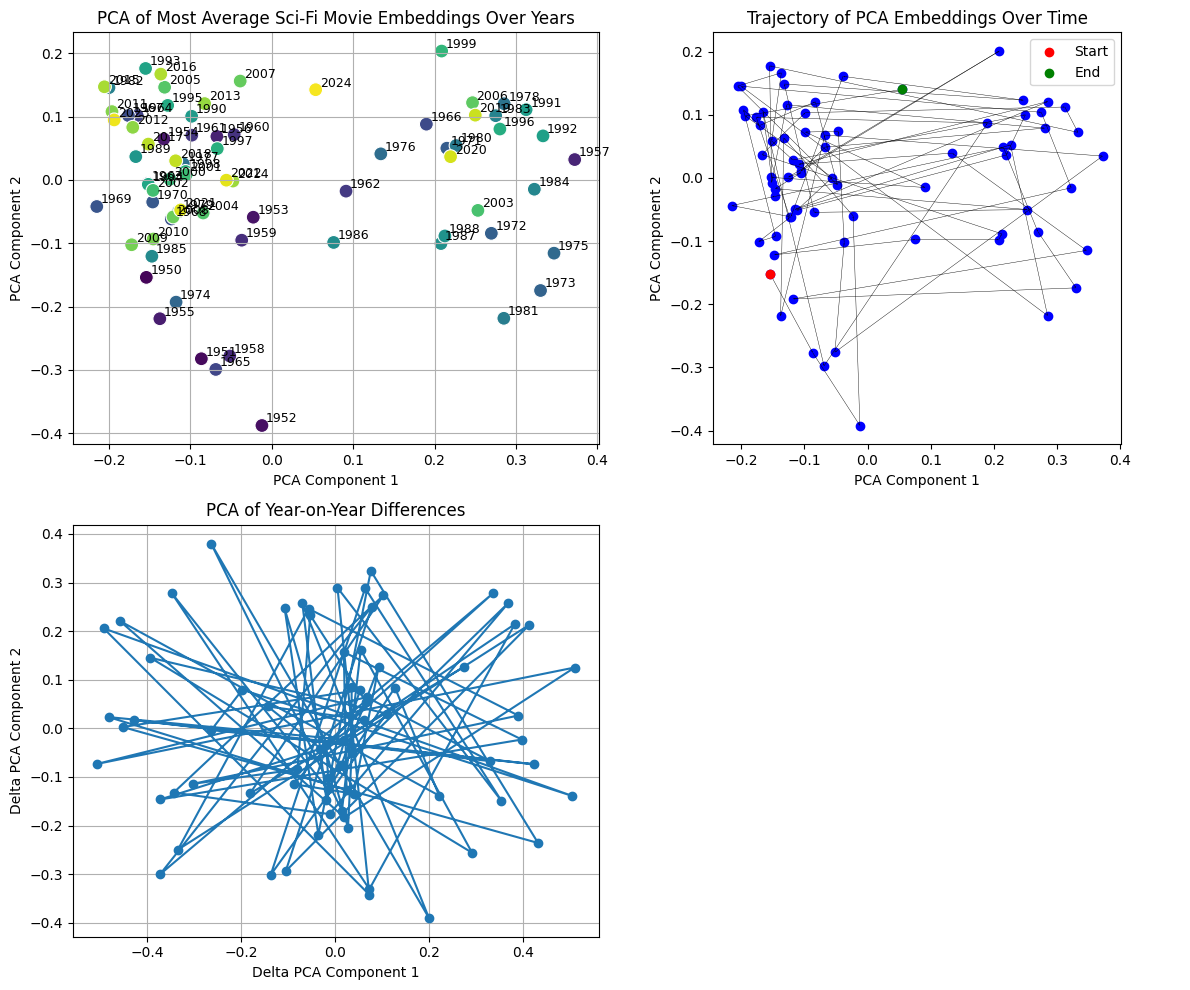

In [92]:
# Filter data only for scifi movies
scifi_df = movie_df[movie_df["new_genre"].apply(lambda x: contains_new_genre(x, "fantasy and scifi"))].reset_index(drop=True)

# Calculate the most average scifi movie per year
most_ave_scifi_movies = []
for year in sorted(scifi_df.year.unique().tolist()):
    # subset df for the year
    year_scifi_df = scifi_df[scifi_df.year == year].reset_index(drop=True)

    # Get all embeddings for movies in 1950
    year_embeddings =np.array([movie_id_to_embedding_map[movie_id] for movie_id in year_scifi_df["movie_id"].tolist()])

    # Calculate pairwise cosine distance matrix
    year_distance_matrix = cdist(year_embeddings, year_embeddings, metric='cosine')

    # Get argmin of sum of distances
    year_most_ave_movie = year_scifi_df.iloc[np.argmin(year_distance_matrix.sum(axis=0))]

    most_ave_scifi_movies.append(year_most_ave_movie)

most_ave_scifi_movies_df = pd.DataFrame(most_ave_scifi_movies)

# All embeddings for most average scifi movies
most_ave_scifi_embeddings = np.array([movie_id_to_embedding_map[movie_id] for movie_id in most_ave_scifi_movies_df["movie_id"].tolist()])

scifi_pcaed_embeddings = PCA(n_components=2).fit_transform(most_ave_scifi_embeddings)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# --- Subplot 1: PCA scatter of embeddings ---
sns.scatterplot(
    x=pcaed_embeddings[:, 0],
    y=pcaed_embeddings[:, 1],
    hue=most_ave_scifi_movies_df["year"],
    palette="viridis",
    s=100,
    ax=ax[0,0]  # <-- plot on this axis
)

for i, year in enumerate(most_ave_scifi_movies_df["year"]):
    ax[0,0].text(pcaed_embeddings[i, 0]+0.005, pcaed_embeddings[i, 1]+0.005, year, fontsize=9)

ax[0,0].set_title("PCA of Most Average Sci-Fi Movie Embeddings Over Years")
ax[0,0].set_xlabel("PCA Component 1")
ax[0,0].set_ylabel("PCA Component 2")
ax[0,0].grid()
ax[0,0].legend_.remove()  # remove legend if needed

# --- Subplot 2: Trajectory plot ---
xs = scifi_pcaed_embeddings[:, 0]
ys = scifi_pcaed_embeddings[:, 1]

dx = xs[1:] - xs[:-1]
dy = ys[1:] - ys[:-1]

ax[0,1].scatter(xs, ys, color='blue')  # plot points
ax[0,1].quiver(xs[:-1], ys[:-1], dx, dy, angles='xy', scale_units='xy', scale=1, width=0.001)

ax[0,1].scatter(xs[0], ys[0], color='red', label='Start')
ax[0,1].scatter(xs[-1], ys[-1], color='green', label='End')

ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("PCA Component 1")
ax[0,1].set_ylabel("PCA Component 2")
ax[0,1].set_title("Trajectory of PCA Embeddings Over Time")
ax[0,1].legend()

# --- Subplot 3: PCA of year-on-year differences ---
deltas = [most_ave_scifi_embeddings[i+1] - most_ave_scifi_embeddings[i] for i in range(len(most_ave_scifi_embeddings)-1)]
pca = PCA(n_components=2)
delta_proj = pca.fit_transform(deltas)

ax[1,0].plot(delta_proj[:,0], delta_proj[:,1], marker='o')
ax[1,0].set_title("PCA of Year-on-Year Differences")
ax[1,0].set_xlabel("Delta PCA Component 1")
ax[1,0].set_ylabel("Delta PCA Component 2")
ax[1,0].grid()

# Optional: hide empty subplot
ax[1,1].axis('off')

plt.tight_layout()
plt.show()


This proved to be still absolutely useless. Let me try another mean method (maybe geometric mean).

## KDE Plots

Try seeing the KDE plot of a few year blocks, let's say decades

Summary:
- Dimensionality Reduction method: PCA
- Subset of data: Fantasy and Scifi movies (new genre classification)
- Plotting method: KDE

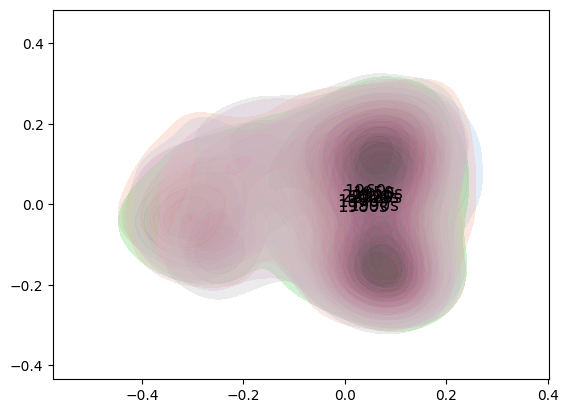

In [86]:
# Start year for each decade
decade_starts = list(range(1950, 2030, 10))

# Get all scifi movies
scifi_df = movie_df[movie_df["new_genre"].apply(lambda x: contains_new_genre(x, "fantasy and scifi"))].reset_index(drop=True)

# All scifi movie embeddings
scifi_embeddings = np.array([movie_id_to_embedding_map[movie_id] for movie_id in scifi_df["movie_id"].tolist()])

# Run PCA on all scifi embeddings
pca = PCA(n_components=2)
scifi_pcaed_embeddings = pca.fit_transform(scifi_embeddings)

# For each decade, get all scifi movies
decade_scifi_movies = {}
for start_year in decade_starts:
    end_year = start_year + 9
    decade_scifi_movies[f"{start_year}s"] = scifi_df[
        (scifi_df.year.astype(int) >= start_year)
        & (scifi_df.year.astype(int) <= end_year)
    ].reset_index(drop=True)

# Map movie_id to pcaed embedding
movie_df_to_umaped_embedding_map = {
    movie_id: scifi_pcaed_embeddings[idx]
    for idx, movie_id in enumerate(scifi_df["movie_id"].tolist())
}

# For each decade, plot the KDE of the PCAed embeddings
for year in decade_starts:
    decade_embeddings = np.array([movie_df_to_umaped_embedding_map[movie_id] for movie_id in decade_scifi_movies[f"{year}s"]["movie_id"].tolist()])
    sns.kdeplot(
        x=decade_embeddings[:,0],
        y=decade_embeddings[:,1],
        fill=True,
        alpha=0.3
    )
    # Label the decade
    plt.text(np.mean(decade_embeddings[:,0]), np.mean(decade_embeddings[:,1]), f"{year}s", fontsize=12)
plt.show()

# Umap

In [ ]:
# Use umap to reduce dimensions of all scifi movies regardless of year
import umap
umap_reducer = umap.UMAP(n_components=2, random_state=42)
scifi_embeddings = np.array([movie_id_to_embedding_map[movie_id] for movie_id in scifi_df["movie_id"].tolist()])
umaped_embeddings = umap_reducer.fit_transform(scifi_embeddings)

In [ ]:
umaped_embeddings.shape

In [ ]:
movie_df_to_umaped_embedding_map = {
    movie_id: umaped_embeddings[idx]
    for idx, movie_id in enumerate(scifi_df.movie_id)
}

In [ ]:
# Now plot a scatter plot of the umap embeddings for the years 1950, 1980, 2000, 2020
plt.figure(figsize=(12, 8))
years_to_plot = list(range(1950, 2025, 10))
for year in years_to_plot:
    year_scifi_df = scifi_df[scifi_df.year == str(year)].reset_index(drop=True)
    year_umap_embeddings = np.array([movie_df_to_umaped_embedding_map[movie_id] for movie_id in year_scifi_df["movie_id"].tolist()])
    plt.scatter(year_umap_embeddings[:, 0], year_umap_embeddings[:, 1], alpha=0.6)
plt.legend()
plt.title("UMAP Embeddings of Sci-Fi Movies by Year")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()

In [ ]:
# Try KDE 

for year in sorted(scifi_df.year.unique().tolist()):
    year_embeddings = np.array([movie_df_to_umaped_embedding_map[movie_id] for movie_id in scifi_df[scifi_df.year == year]["movie_id"].tolist()])
    sns.kdeplot(
        x=year_embeddings[:,0],
        y=year_embeddings[:,1],
        fill=True,
        alpha=0.3
    )
plt.show()


# 